# Predictive Model (Lung Cancer)

In [2]:
import pandas as pd

# Load the uploaded dataset
file_path = "survey lung cancer.csv"
df = pd.read_csv(file_path)

# Display basic information about the dataset
df.info(), df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   GENDER                 309 non-null    object
 1   AGE                    309 non-null    int64 
 2   SMOKING                309 non-null    int64 
 3   YELLOW_FINGERS         309 non-null    int64 
 4   ANXIETY                309 non-null    int64 
 5   PEER_PRESSURE          309 non-null    int64 
 6   CHRONIC DISEASE        309 non-null    int64 
 7   FATIGUE                309 non-null    int64 
 8   ALLERGY                309 non-null    int64 
 9   WHEEZING               309 non-null    int64 
 10  ALCOHOL CONSUMING      309 non-null    int64 
 11  COUGHING               309 non-null    int64 
 12  SHORTNESS OF BREATH    309 non-null    int64 
 13  SWALLOWING DIFFICULTY  309 non-null    int64 
 14  CHEST PAIN             309 non-null    int64 
 15  LUNG_CANCER            

(None,
   GENDER  AGE  SMOKING  YELLOW_FINGERS  ANXIETY  PEER_PRESSURE  \
 0      M   69        1               2        2              1   
 1      M   74        2               1        1              1   
 2      F   59        1               1        1              2   
 3      M   63        2               2        2              1   
 4      F   63        1               2        1              1   
 
    CHRONIC DISEASE  FATIGUE   ALLERGY   WHEEZING  ALCOHOL CONSUMING  COUGHING  \
 0                1         2         1         2                  2         2   
 1                2         2         2         1                  1         1   
 2                1         2         1         2                  1         2   
 3                1         1         1         1                  2         1   
 4                1         1         1         2                  1         2   
 
    SHORTNESS OF BREATH  SWALLOWING DIFFICULTY  CHEST PAIN LUNG_CANCER  
 0                    

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Encode categorical features
df_encoded = df.copy()
le_gender = LabelEncoder()
le_cancer = LabelEncoder()
df_encoded["GENDER"] = le_gender.fit_transform(df_encoded["GENDER"])
df_encoded["LUNG_CANCER"] = le_cancer.fit_transform(df_encoded["LUNG_CANCER"])

# Define features and target
X = df_encoded.drop("LUNG_CANCER", axis=1)
y = df_encoded["LUNG_CANCER"]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred, target_names=le_cancer.classes_)
conf_matrix = confusion_matrix(y_test, y_pred)

report, conf_matrix


('              precision    recall  f1-score   support\n\n          NO       0.50      0.50      0.50         2\n         YES       0.98      0.98      0.98        60\n\n    accuracy                           0.97        62\n   macro avg       0.74      0.74      0.74        62\nweighted avg       0.97      0.97      0.97        62\n',
 array([[ 1,  1],
        [ 1, 59]], dtype=int64))

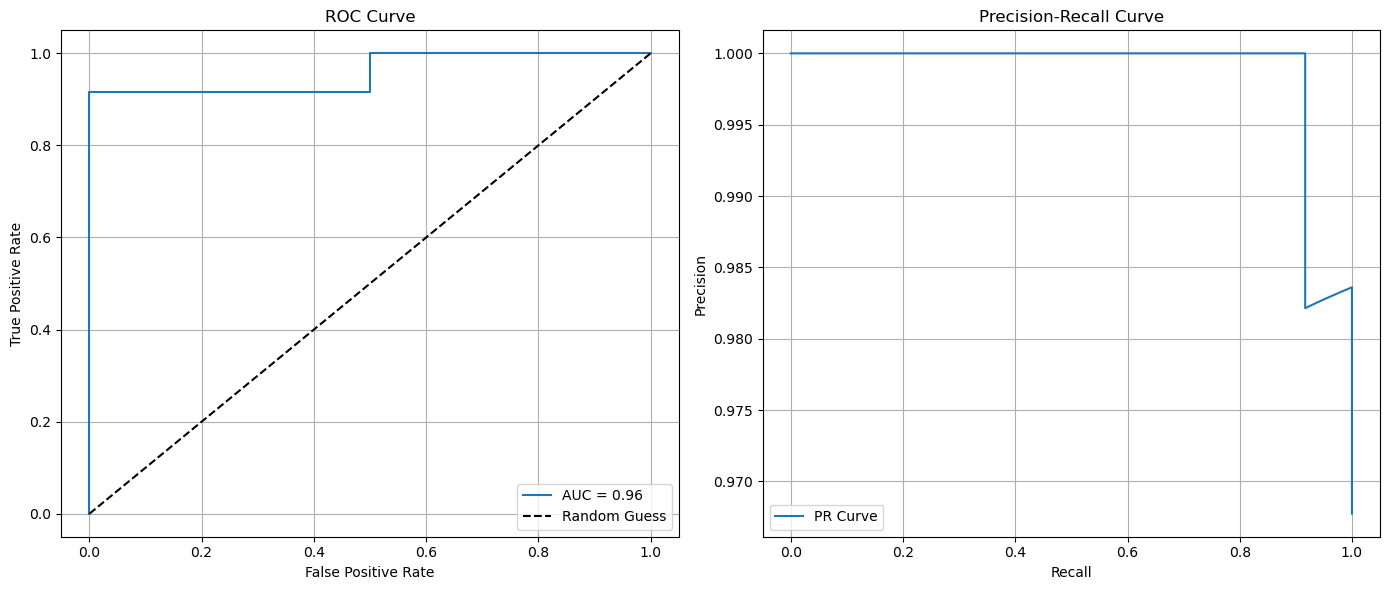

In [4]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
import matplotlib.pyplot as plt

# Get prediction probabilities
y_scores = clf.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_scores)

# Plotting both curves
plt.figure(figsize=(14, 6))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label="PR Curve")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid(True)

plt.tight_layout()
plt.show()


In [5]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Define individual classifiers
clf1 = LogisticRegression(max_iter=1000, random_state=42)
clf2 = DecisionTreeClassifier(random_state=42)
clf3 = SVC(probability=True, random_state=42)

# Create a VotingClassifier (soft voting)
voting_clf = VotingClassifier(
    estimators=[('lr', clf1), ('dt', clf2), ('svc', clf3)],
    voting='soft'
)

# Train Voting Classifier
voting_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred_voting = voting_clf.predict(X_test)
voting_accuracy = accuracy_score(y_test, y_pred_voting)
voting_report = classification_report(y_test, y_pred_voting, target_names=le_cancer.classes_)
voting_conf_matrix = confusion_matrix(y_test, y_pred_voting)

voting_accuracy, voting_report, voting_conf_matrix


(0.9838709677419355,
 '              precision    recall  f1-score   support\n\n          NO       1.00      0.50      0.67         2\n         YES       0.98      1.00      0.99        60\n\n    accuracy                           0.98        62\n   macro avg       0.99      0.75      0.83        62\nweighted avg       0.98      0.98      0.98        62\n',
 array([[ 1,  1],
        [ 0, 60]], dtype=int64))

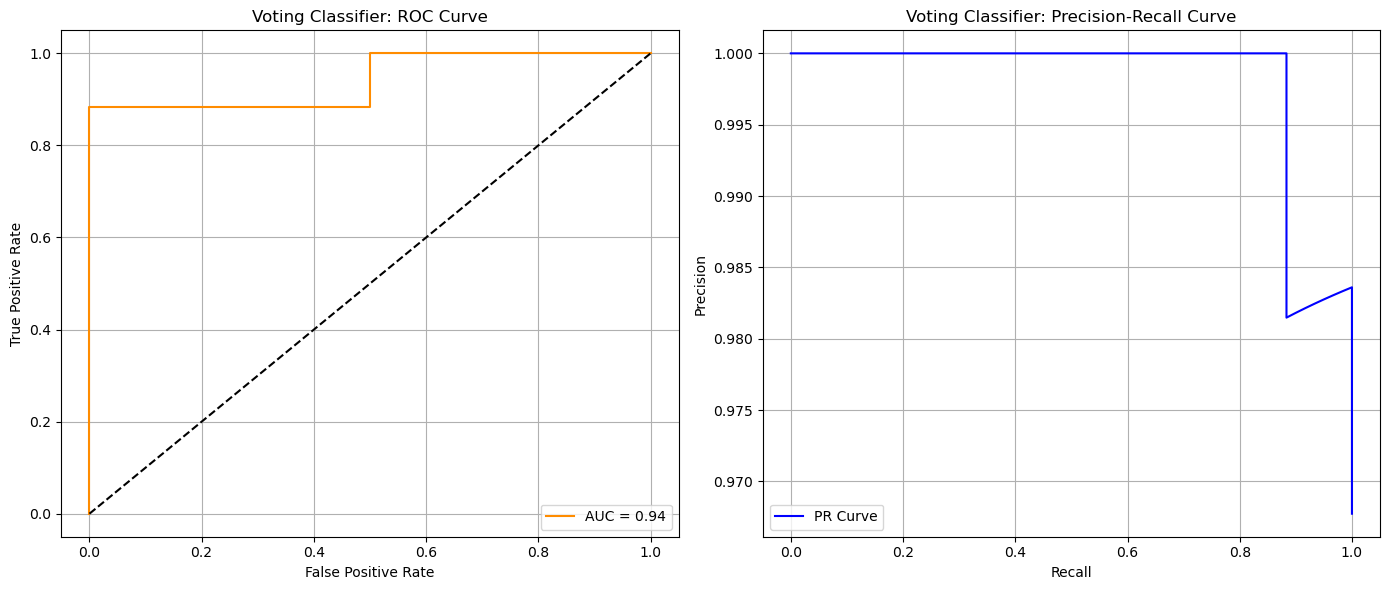

In [6]:
# Get prediction probabilities for ROC and PR curves
y_scores_voting = voting_clf.predict_proba(X_test)[:, 1]

# Compute ROC and AUC
fpr_voting, tpr_voting, _ = roc_curve(y_test, y_scores_voting)
roc_auc_voting = auc(fpr_voting, tpr_voting)

# Compute Precision-Recall
precision_voting, recall_voting, _ = precision_recall_curve(y_test, y_scores_voting)

# Plotting
plt.figure(figsize=(14, 6))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr_voting, tpr_voting, label=f"AUC = {roc_auc_voting:.2f}", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Voting Classifier: ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall_voting, precision_voting, label="PR Curve", color='blue')
plt.title("Voting Classifier: Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid(True)

plt.tight_layout()
plt.show()
